# MPSC Inference and Results lookup
<hr >

> In this notebook we will check our model performance in more details

## Table Of Content
<hr >

> 1. [Imports and Load](#Imports-and-Load)
>     - [Load data](#Load-data)
>     - [Load Model and Predict](#Load-Model-and-Predict)
> 2. [Error-analysis](#Error-analysis)
>     - [a quick look on the top worst predictions](#a-quick-look-on-the-top-worst-predictions)
>     - [which category has worst mae](#which-category-has-worst-mae)
>     - [name wordcloud based on error](#name-wordcloud-based-on-error)
>     - [item_description wordcloud based on error](#item_description-wordcloud-based-on-error)

## Imports and Load
<hr >

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # for creating interactive visualizations
import seaborn as sns # data visualization library based on matplotlib
from wordcloud import WordCloud, STOPWORDS
import fasttext # used here for language detection
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import layers, Model
import joblib

2022-01-25 00:50:00.813957: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-25 00:50:00.813987: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
DATA_PATH = '../data/'
MODELS_PATH = '../models/'

TARGET = 'price'
SEED = 123
MAX_NUM_WORDS_NAME = 40000
MAX_NUM_WORDS_DESC = 80000
MAX_SEQ_LEN_NAME = 20
MAX_SEQ_LEN_DESC = 64

In [5]:
class Transformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    
class ItemSelector(Transformer):
    def __init__(self, field, fillna_value=None, fillna_from_field=None):
        self.field = field
        self.fillna_value = fillna_value
        self.fillna_from_field = fillna_from_field
    
    def transform(self, df):
        series = df[self.field]
        if self.fillna_from_field:
            series = series.fillna(df[self.fillna_from_field])
            
        if self.fillna_value:
            series = series.fillna(self.fillna_value)
        
        return series
    
    
class SubCategorySpliter(Transformer):
    def __init__(self, delimiter='/', maxsplit=2, nth_split=0):
        self.delimiter = delimiter
        self.nth_split = nth_split
        self.maxsplit = maxsplit
        
    def transform(self, series):
        return series.apply(lambda x: x.split(self.delimiter, self.maxsplit)[self.nth_split])
    
    
class SeriesToArray(Transformer):
    def __init__(self, shape=(-1, 1)):
        self.shape = shape
        
    def transform(self, series):
        return series.values.reshape(self.shape)
    
    
class TextToSeq(Transformer):
    def __init__(
        self,
        num_words=None,
        filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
        lower=True,
        maxlen=100,
        sparse=True,
        dtype=np.uint32
    ):
        self.num_words = num_words
        self.filters = filters
        self.lower = lower
        self.maxlen = maxlen
        self.sparse = sparse
        self.dtype = dtype
        
    def fit(self, series, y=None):
        self.tokenizer = Tokenizer(num_words=self.num_words, filters=self.filters, lower=self.lower)
        self.tokenizer.fit_on_texts(series)
        
        return self
        
    def transform(self, series):
        seqs = self.tokenizer.texts_to_sequences(series)
        pad_seqs = pad_sequences(seqs, maxlen=self.maxlen, dtype=self.dtype)
        if self.sparse:
            pad_seqs = csr_matrix(pad_seqs)
        
        return pad_seqs
    
    
class DataGenerator(keras.utils.Sequence):
    def __init__(self, df, pipes, target, batch_size=1024, train=True, shuffle=True):
        self.df = df
        self.pipes = pipes
        self.target = target
        self.train = train
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.df)/ self.batch_size))
    
    def __getitem__(self, idx):
        sub_idxs = self.idxs[idx*self.batch_size:(idx+1)*self.batch_size]
        sub_df = self.df.iloc[sub_idxs]
        X, y = self.__data_generation(sub_df)
        
        return X, y

    def on_epoch_end(self):
        self.idxs = np.arange(len(self.df))
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __data_generation(self, sub_df):
        X = [pipe.transform(sub_df) for pipe in self.pipes]
        if self.train:
            return X, np.log1p(sub_df[self.target].values)
        
        return X

### Load data

In [7]:
df_test = pd.read_csv(DATA_PATH+ 'mpsc_test.csv')
pipes = joblib.load(MODELS_PATH+ 'pipes.pkl')
dg_test = DataGenerator(df=df_test, pipes=pipes, target=TARGET, batch_size=2**12, shuffle=False)

### Load Model and Predict

In [9]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
    
class CustomOutputLayer(layers.Layer):
    def __init__(self, min_val, max_val, **kwargs):
        super(CustomOutputLayer, self).__init__(**kwargs)
        self.min_val = min_val
        self.max_val = max_val
        
    def call(self, inputs):
        outputs = tf.sigmoid(inputs)* (self.max_val- self.min_val)+ self.min_val
        output = tf.reduce_mean(outputs, axis=1, keepdims=True)
        
        return output
        
def get_model(seq_1_len, seq_2_len, feats_len, seq_1_max, seq_2_max, out_min_val, out_max_val, use_cuslayer=True):
    seq_1 = layers.Input((seq_1_len,))
    s_1 = layers.Embedding(seq_1_max, 128)(seq_1)
    s_1 = TransformerBlock(128, 4, 128)(s_1)
    s_1 = layers.GlobalAvgPool1D()(s_1)
    
    seq_2 = layers.Input((seq_2_len,))
    s_2 = layers.Embedding(seq_2_max, 128)(seq_2)
    s_2 = TransformerBlock(128, 4, 128)(s_2)
    s_2 = layers.GlobalAvgPool1D()(s_2)
    
    rest_ = layers.Input((feats_len,))
    
    vec = layers.Concatenate(axis=1)([s_1, s_2, layers.Dense(64)(rest_)])
    vec = layers.Dense(64)(vec)
    if use_cuslayer:
        out = CustomOutputLayer(out_min_val, out_max_val)(vec)
    else:
        out = layers.Dense(1)(vec)
        
    model = Model(inputs=[seq_1, seq_2, rest_], outputs=[out])
    
    return model

In [12]:
model_1 = get_model(pipes[0].transform(df_test.iloc[0:1]).shape[1],
                  pipes[1].transform(df_test.iloc[0:1]).shape[1],
                  pipes[2].transform(df_test.iloc[0:1]).shape[1],
                  MAX_NUM_WORDS_NAME,
                  MAX_NUM_WORDS_DESC,
                  0,
                  8
                 )
model_1.load_weights(MODELS_PATH+ 'model_1_weights.hdf')
df_test['pred_price'] = np.expm1(model_1.predict(dg_test, verbose=1))

2022-01-25 00:52:37.482378: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-25 00:52:37.483318: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-25 00:52:37.483508: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-01-25 00:52:37.483664: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-01-25 00:52:37.483815: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

73/73 [==============================] - 350s 5s/step


## Error analysis
<hr >

In [16]:
msle = np.mean((np.log1p(df_test['pred_price']) - np.log1p(df_test['price']))** 2)
print(f'Test dataset msle: {msle}')

Test dataset msle: 0.19201983420331936


In [17]:
df_test['abs_err'] = np.abs(df_test['price']- df_test['pred_price'])
df_test['item_description'] = df_test['item_description'].fillna('No description yet')
df_test['category_name'] = df_test['category_name'].fillna('Other/Other/Other')
df_test['brand_name'] = df_test['brand_name'].fillna('Other')
df_test['main_cat'] = df_test['category_name'].apply(lambda x: x.split('/', maxsplit=2)[0])
df_test = df_test[[col for col in df_test.columns if not 'price' in col]+ ['price', 'pred_price']].drop('train_id', axis=1)
df_test

,name,item_condition_id,category_name,brand_name,shipping,item_description,abs_err,main_cat,price,pred_price
0,On hold for Chelseychu,2,Women/Women's Handbags/Shoulder Bag,Hello Kitty,0,Black faux leather hello kitty satchel comes w...,0.807568,Women,31.0,30.192432
1,Lace up leggings,2,Women/Pants/Casual Pants,Other,1,Only worn for picture,4.041965,Women,15.0,10.958035
2,Zipper High Top All Star Converse,3,Women/Shoes/Fashion Sneakers,Converse,0,Size 7 women's Great for your feet! Check out ...,0.952915,Women,26.0,25.047085
3,Sperry,3,Kids/Girls 2T-5T/Shoes,Other,0,Pink Size 6 toddler Used Very good condition G...,1.977699,Kids,16.0,14.022301
4,Lipsense set,1,Beauty/Makeup/Lips,SeneGence,1,Bella color with Glossy gloss and oops remover,0.236229,Beauty,50.0,49.763771
...,...,...,...,...,...,...,...,...,...,...
296502,Hatchimals,1,Kids/Toys/Stuffed Animals & Plush,Other,0,Hatchimals Hatchimals Penguala pink/yellow new...,54.786842,Kids,161.0,106.213158
296503,Men's Medium Beige Columbia Sweatshirt,3,"Men/Sweats & Hoodies/Sweatshirt, Pullover",Columbia,0,Men's medium beige Columbia sweatshirt - soft ...,1.118613,Men,14.0,15.118613
296504,Tommy Hilfiger T,3,Women/Tops & Blouses/T-Shirts,Tommy Hilfiger,0,"Small yellow spot next to tag, not noticeable ...",3.423761,Women,14.0,10.576239
296505,Womens Stretchy Plus Size Dress Sz 2XL,1,Women/Dresses/Knee-Length,Other,0,Womens Plus Size Dress Size 2XL New With Tags ...,3.392288,Women,16.0,12.607712


half of our predictions have absulte error less than 10.0


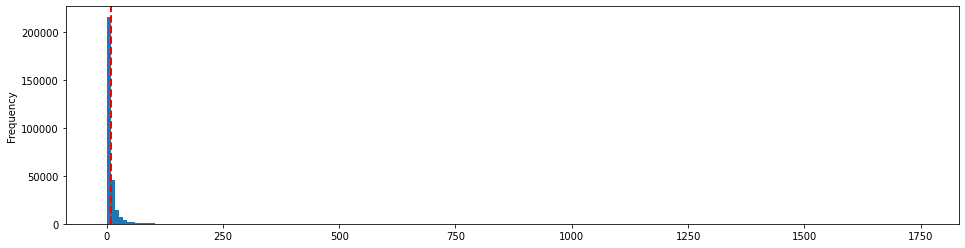

In [19]:
plt.figure(figsize=(16, 4))
df_test['abs_err'].plot.hist(bins=200)
plt.axvline(df_test['abs_err'].mean(), color='r', linestyle='dashed', linewidth=2)
mean_abs_err = df_test['abs_err'].mean()
print(f'half of our predictions have absulte error less than {np.ceil(mean_abs_err)}')

### a quick look on the top worst predictions

In [20]:
df_test.sort_values('abs_err').tail(25)

,name,item_condition_id,category_name,brand_name,shipping,item_description,abs_err,main_cat,price,pred_price
270561,VS Pink Dogs,1,Women/Women's Accessories/Other,Victoria's Secret,0,4 Victoria secret PINK college mini dog ~ NWT ...,883.748804,Women,906.0,22.251196
33186,Giorgio Armani fabric power,1,Beauty/Makeup/Face,Georgio Armani,0,15 power fabric full size 12- fluid eye tint s...,892.576160,Beauty,917.0,24.423840
44717,IPhone 6s Plus,1,Electronics/Cell Phones & Accessories/Cell Pho...,Other,1,128Gb,893.517998,Electronics,941.0,47.482002
180167,MONOGRAM SAINT LAURENT WALLET MATELASSÉ,1,Women/Women's Handbags/Shoulder Bag,Saint Laurent,1,"$ 1,550.00 RETAIL MONOGRAM SAINT LAURENT CHAIN...",897.585999,Women,1525.0,627.414001
38593,10 [rm] ITunes gift cards,1,Other/Office supplies/Electronics,Other,1,"10 brand new ITunes gift cards, with [rm] valu...",910.667912,Other,950.0,39.332088
142999,universal Unlocked IPhone 7 128gigs,1,Electronics/Cell Phones & Accessories/Cell Pho...,Apple,0,Brand new universal Unlocked IPhone 7 128gigs ...,924.496616,Electronics,956.0,31.503384
268295,Louis Vuitton luggage,3,Vintage & Collectibles/Bags and Purses/Luggage,Louis Vuitton,0,"Gently used,",942.082733,Vintage & Collectibles,1009.0,66.917267
96985,Super Huge Custom Listing,4,Vintage & Collectibles/Collectibles/Other,Other,1,Up for sale: U.S. 2004-S Wisconsin State Quart...,949.991196,Vintage & Collectibles,1050.0,100.008804
155399,RESERVED Platinum Engagement Ring 1 TCW,4,Women/Jewelry/Rings,Other,1,Vintage platinum engagement ring with solitair...,994.788040,Women,1100.0,105.211960
43621,MCM Embellished Bundle,1,Women/Women's Handbags/Shoulder Bag,MCM Worldwide,1,No description yet,1014.332916,Women,1200.0,185.667084


### which category has worst mae

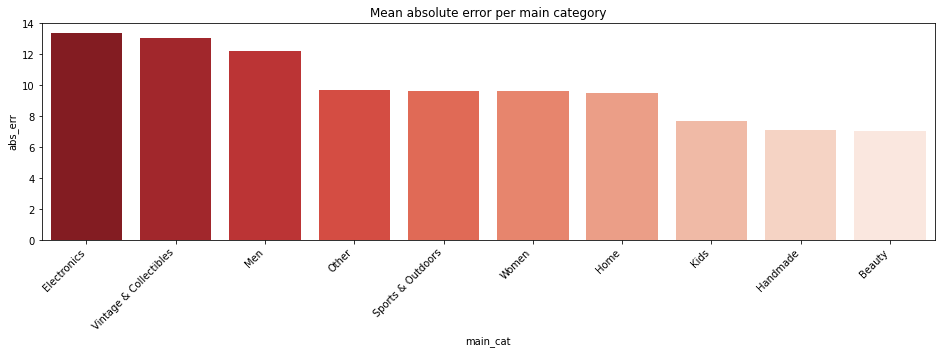

In [21]:
df_ = df_test.groupby('main_cat')['abs_err'].mean().sort_values(ascending=False).reset_index()
df_.columns = ['main_cat', 'abs_err']
fig, ax = plt.subplots(figsize=(16, 4))
ax.set(title=f'Mean absolute error per main category')
sns.barplot(data=df_, x='main_cat', y='abs_err', palette=sns.color_palette('Reds_r', n_colors=10), ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

### name wordcloud based on error

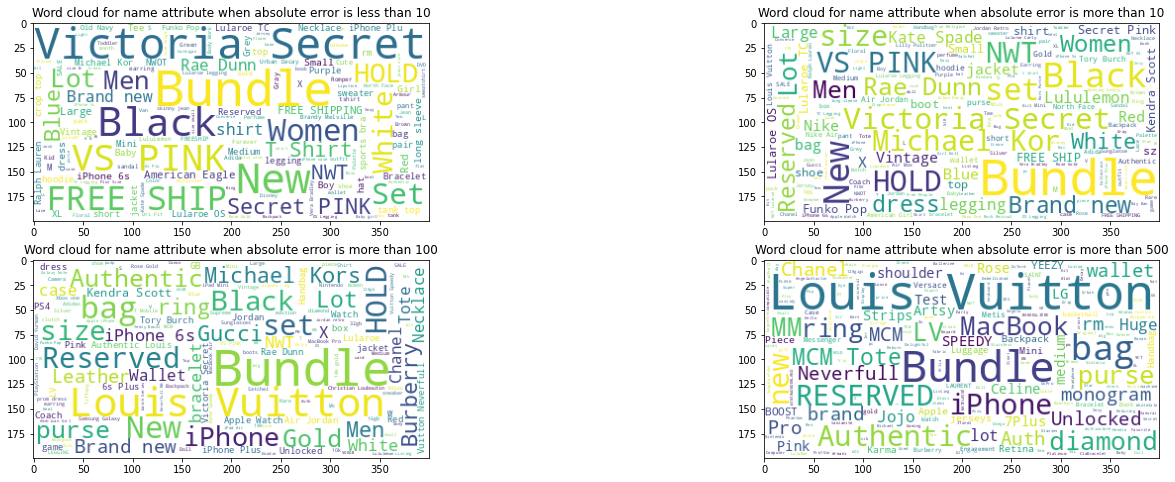

In [23]:
fig, ax = plt.subplots(2, 2,figsize=(24, 8))
for i, r in enumerate([('l', 10), ('g', 10), ('g', 100), ('g', 500)]):
    if r[0] == 'l':
        wordcloud = WordCloud(background_color="white",
                      max_font_size=50,
                      max_words=1000,
                      stopwords=STOPWORDS).generate(' '.join(df_test.loc[df_test['abs_err']< r[1], 'name']))
        ax[i//2, i%2].set(title=f'Word cloud for name attribute when absolute error is less than {r[1]}')
        ax[i//2, i%2].imshow(wordcloud)
        
    else:
        wordcloud = WordCloud(background_color="white",
                      max_font_size=50,
                      max_words=1000,
                      stopwords=STOPWORDS).generate(' '.join(df_test.loc[df_test['abs_err']> r[1], 'name']))
        ax[i//2, i%2].set(title=f'Word cloud for name attribute when absolute error is more than {r[1]}')
        ax[i//2, i%2].imshow(wordcloud)

### item_description wordcloud based on error

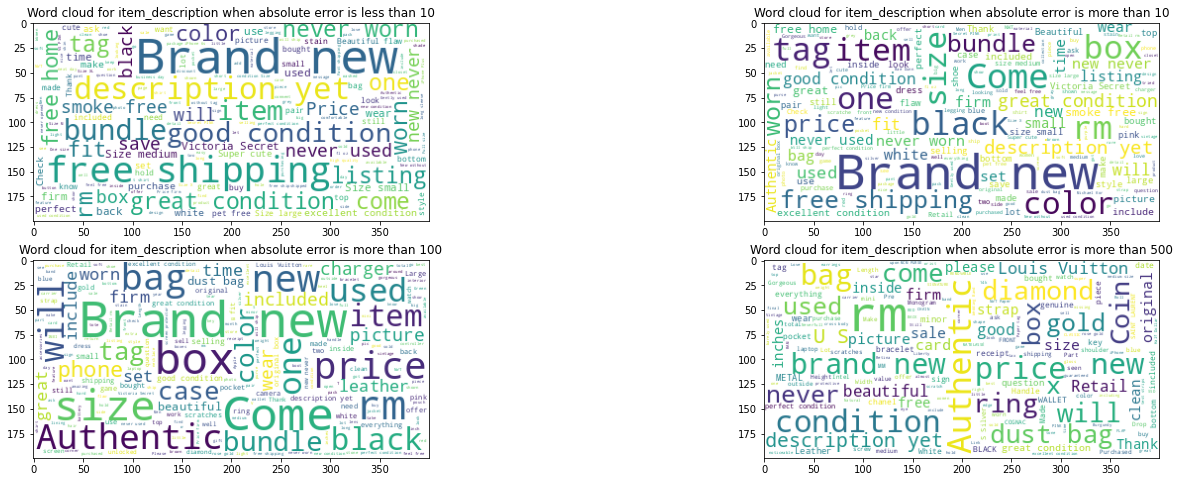

In [24]:
fig, ax = plt.subplots(2, 2,figsize=(24, 8))
for i, r in enumerate([('l', 10), ('g', 10), ('g', 100), ('g', 500)]):
    if r[0] == 'l':
        wordcloud = WordCloud(background_color="white",
                      max_font_size=50,
                      max_words=1000,
                      stopwords=STOPWORDS).generate(' '.join(df_test.loc[df_test['abs_err']< r[1], 'item_description']))
        ax[i//2, i%2].set(title=f'Word cloud for item_description when absolute error is less than {r[1]}')
        ax[i//2, i%2].imshow(wordcloud)
        
    else:
        wordcloud = WordCloud(background_color="white",
                      max_font_size=50,
                      max_words=1000,
                      stopwords=STOPWORDS).generate(' '.join(df_test.loc[df_test['abs_err']> r[1], 'item_description']))
        ax[i//2, i%2].set(title=f'Word cloud for item_description when absolute error is more than {r[1]}')
        ax[i//2, i%2].imshow(wordcloud)